refer : https://www.kaggle.com/zinovadr/mnist-fastai-pytorch-0-98720-ps-15-mins-to-run

In [1]:

# refer : https://www.kaggle.com/zinovadr/mnist-fastai-pytorch-0-98720-ps-15-mins-to-run

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv


In [2]:
from fastai import *
from fastai.vision import *

In [3]:
DATAPATH = Path('/kaggle/input/Kannada-MNIST')

In [4]:
for dirname, _, filename in os.walk(DATAPATH):
    print(filename)

['sample_submission.csv', 'test.csv', 'train.csv', 'Dig-MNIST.csv']


In [5]:
def get_data_labels(csv, label):
    fileraw = pd.read_csv(csv)
    labels = fileraw[label].to_numpy()
    data = fileraw.drop([label],axis=1).to_numpy(dtype=np.float32).reshape((fileraw.shape[0],28,28))
    data = np.expand_dims(data, axis=1)
    return data, labels

In [6]:
train_data, train_labels = get_data_labels(DATAPATH/'train.csv','label')
test_data, test_labels = get_data_labels(DATAPATH/'test.csv','id')
other_data, other_labels = get_data_labels(DATAPATH/'Dig-MNIST.csv','label')

In [7]:
print(f' Train:\tdata shape {train_data.shape}\tlabel shape {train_labels.shape}\n \
Test:\tdata shape {test_data.shape}\tlabel shape {test_labels.shape}\n \
Other:\tdata shape {other_data.shape}\tlabel shape {other_labels.shape}')

 Train:	data shape (60000, 1, 28, 28)	label shape (60000,)
 Test:	data shape (5000, 1, 28, 28)	label shape (5000,)
 Other:	data shape (10240, 1, 28, 28)	label shape (10240,)


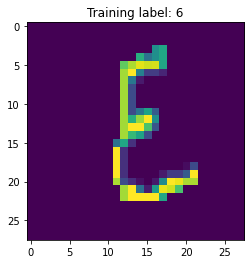

In [8]:
plt.title(f'Training label: {train_labels[6]}')
plt.imshow(train_data[6,0])


In [9]:
np.random.seed(42)

ran_10_pct_idx = (np.random.random_sample(train_labels.shape)) < .001
print(np.random.random_sample(train_labels.shape) < 0.01)

train_90_labels = train_labels[np.invert(ran_10_pct_idx)]
train_90_data = train_data[np.invert(ran_10_pct_idx)]

valid_10_labels = train_labels[ran_10_pct_idx]
valid_10_data = train_data[ran_10_pct_idx]

[False False False False ... False False False False]


In [10]:
class ArrayDataset(Dataset):
    "Dataset for numpy arrays based on fastai example: "
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = len(np.unique(y))
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [11]:
train_ds = ArrayDataset(train_90_data,train_90_labels)
valid_ds = ArrayDataset(valid_10_data,valid_10_labels)
other_ds = ArrayDataset(other_data, other_labels)
test_ds = ArrayDataset(test_data, test_labels)

In [12]:
bs = 256
databunch = DataBunch.create(train_ds, valid_ds, test_ds=test_ds, bs=bs)

In [13]:
def conv2(ni,nf,stride=2,ks=5): 
    return conv_layer(ni,nf,stride=stride,ks=ks)

In [14]:
best_architecture = nn.Sequential(
    conv2(1,32,stride=1,ks=5),
    conv2(32,32,stride=1,ks=5),
    conv2(32,32,stride=2,ks=8),
    nn.Dropout(0.4),
    
    conv2(32,64,stride=1,ks=5),
    conv2(64,64,stride=1,ks=5),
    conv2(64,64,stride=2,ks=5),
    nn.Dropout(0.4),
    
    Flatten(),
    nn.Linear(3136, 256),
    relu(inplace=True),
    nn.BatchNorm1d(256),
    nn.Dropout(0.4),
    nn.Linear(256,10)
)

In [15]:
learn = Learner(databunch, best_architecture, loss_func = nn.CrossEntropyLoss(), metrics=[accuracy] )

In [16]:
learn.fit_one_cycle(42)

epoch,train_loss,valid_loss,accuracy,time
0,0.146362,0.045879,0.985075,00:06
1,0.050633,0.004681,1.000000,00:05
2,0.034185,0.005864,1.000000,00:05
3,0.026688,0.001321,1.000000,00:05
4,0.023133,0.008773,1.000000,00:05
5,0.021023,0.000521,1.000000,00:05
6,0.024057,0.000797,1.000000,00:05
7,0.019505,0.000104,1.000000,00:06
8,0.022035,0.002003,1.000000,00:05
9,0.016520,0.000164,1.000000,00:05


In [17]:
preds, ids = learn.get_preds(DatasetType.Test)
y = torch.argmax(preds, dim=1)

In [18]:
submission = pd.DataFrame({'id': ids, 'label': y})
submission.to_csv(path_or_buf="submission.csv", index=False)

In [20]:
#learn.export()
# not working